# Analysis of July 7th 2022 Flight

Goal: 
1. Pick apart data to get idea of what went wrong.  
    * Statistical plots on airspeed
    * Correlations and Cross Correlations

2. Formulate Loiter Scoring Mechanism
    - [x] Separate loiters
    - [x] Separate by highest power draw
    - [x] Plot worst loiters in time
    - [x] Plot correlation matrix for worst loiters

In [1]:
## Importing Modules ##
from os import sys
sys.path.append('../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders
import plotly.express as px


In [2]:
# Importing data from BIN files #

#df = main.get_data("Alton", "june15_2022.BIN", "10ms")
#df = main.get_data("Alton", "july7_2022.BIN", "10ms")
#df = main.get_data("Alton","july8_2022.BIN", "100ms")

In [3]:
## Pickling that DF for Later ##

#df.to_pickle("./data/july7_2022_100Hz.pkl")

## Unpickling 
df_100Hz = pd.read_pickle("../data/july7_2022_100Hz.pkl")
#df_60Hz = pd.read_pickle("./data/june15_2022_60Hz.pkl")
#df_1Hz = pd.read_pickle("./data/june15_2022_1Hz.pkl")

df = df_100Hz.interpolate(method="linear")

In [4]:
# Vehicle parameters
prop = propellers.aeronaut185x12() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_72350/3541916034.py:8: RuntimeWarning: invalid value encountered in reciprocal
  rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_72350/3541916034.py:10: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_72350/3541916034.py:16: RuntimeWarning: invalid value encountered in reciprocal
  Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_72350/3541916034.py:26: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_72350/3541916034.py:26:

Freewheel thrust coefficient:  -0.00804445463199624 
 Advance Ratio:  0.8386905840958647 
 CP Freewheel:  5.129680916149404e-10


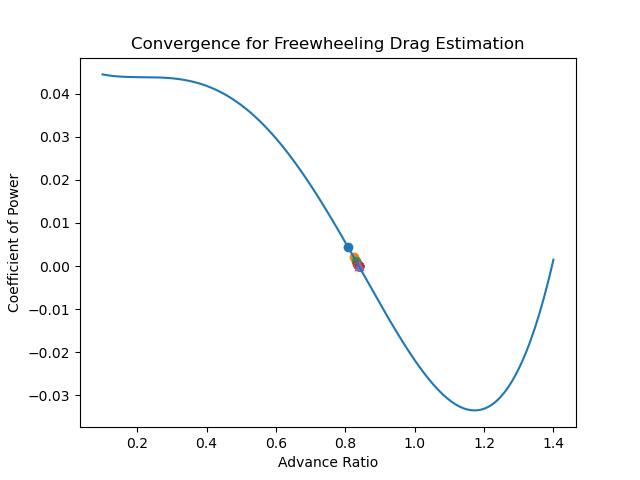

Propeller Drag[nan nan nan ...  0.  0.  0.]


/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  CD = p_required * (q * v * aircraft.area)**-1
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:117: RuntimeWarning: invalid value encountered in reciprocal
  CD = p_required * (q * v * aircraft.area)**-1
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:18: RuntimeWarning: divide by zero encountered in reciprocal
  CL = aircraft.weight * (np.cos(phi) * q * aircraft.area)**-1
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:18: RuntimeWarning: invalid value encountered in reciprocal
  CL = aircraft.weight * (np.cos(phi) * q * aircraft.area)**-1


In [5]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter

v_dem = df["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)
P_desc = cl_finders.desc2preq(createv, prop, rho, v_tas, n, q, Vd_tas)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)
Cd_desc = cl_finders.preq2cd(createv, v_tas, q, P_desc)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

# Inertial Measurement Unit
xp_acc = df["XAcc_IMU"].to_numpy()                       # Acceleration in X direction of the IMU
zp_acc = df["ZAcc_IMU"].to_numpy()                       # Acceleration in Z direction of the IMU

pitchp = 0.585 * (np.pi/180)  # Pitch perturbation from IMU orientation (Degrees)
phip = 4 * (np.pi/180)  # Roll perturbation from IMU orientation (Degrees)

U_dotp = xp_acc - 9.807 * np.sin(pitch+pitchp)
W_dotp = zp_acc + 9.807 * np.cos(pitch+pitchp) * np.cos(phi+phip)

In [6]:
# Supplimental Values
df["PowerElectrical_2"] = df["MainBatteryCurrent"] * df["MainBatteryVoltage"]
df["PowerElectrical"] = df["MainBatteryCurrent"] * df["EscVoltage"]
df["PowerESC"] = df["EscVoltage"] * df["EscCurrent"]
df["Throttle"] = (df["Throttle"]-1100)*(1.0/800.0)

## Loiter Scoring Algorithm 
The idea is to understand how far off the loiter performance is off where the aircraft should be operating.  

Some quick ideas:

$ P_{prop} = P_{req} + P_{potential} + P_{kinetic} + P_{thermal}$

* Aircraft power can be estimated from a few factors:
    * Power required + Potential Power + Kinetic Power
    * Inputs are:
        * Airspeed $ V_{\infty} $
            * Temperature
            * Pressure differential
        * Reference area $S$
        * Rate of Climb $ \dot{h} $
        * Drag polar measurement of aircraft $ C_L - C_D $

$ P_{prop} = \frac{1}{2} \rho S V_{infty}^3 C_D + mg \dot{h} $ 

$ P_{elec_{model}} = P_{prop} / (\eta_{DT} \eta_{prop}) $

From the two equations, we can easily calculate the error between the actual data and that expected by the model:

$ \% Error = \frac{P_{elec_{actual}} - P_{elec_{model}}}{P_{elec_{model}}} $

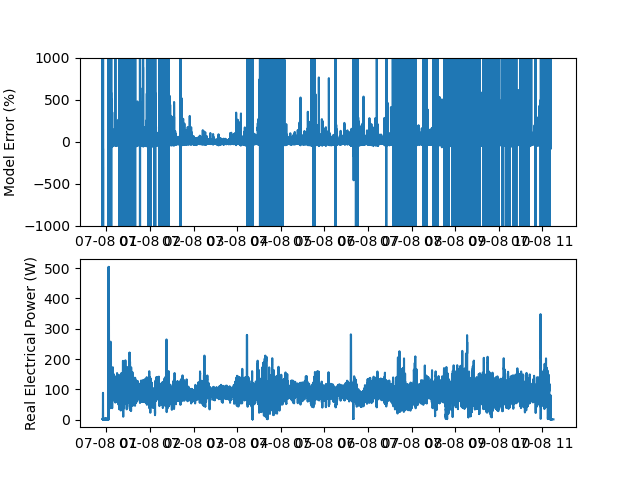

In [7]:
# Comparing real electrical power, with predicted power from instantaneous calculation

P_prop = P_eta + (-1 * createv.weight * Vd_tas)
P_elec_model = (P_prop / eff) + P_systems

# Adding results to DataFrame
df["ModelPower"] = P_elec_model

# Getting % Error from Actual Electrical Power
df["ModelError"] = ((df["PowerElectrical"] - df["ModelPower"]) / df["ModelPower"]) * 100

## Plotting 
plt.figure()
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, df.ModelError)
ax1.set_ylabel("Model Error (%)")
ax1.set_ylim([-1000,1000])

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, df.PowerElectrical)
ax2.set_ylabel("Real Electrical Power (W)")
plt.show()

In [8]:
print(eff[J < 0.79].mean())

0.5857953340828506


In [9]:
# Getting Estimated Drag, based on certain flight-test data

flight_model_eta = pd.read_pickle("../Results/2022-06-15_eta.pkl")
flight_model_ct = pd.read_pickle("../Results/2022-06-15_ct.pkl")

CD_eta = flight_model_eta.Polar[0] + ((flight_model_eta.Polar[1]*np.pi*createv.AR)**-1 * (CL - flight_model_eta.Polar[2])**2)
CD_ct = flight_model_ct.Polar[0] + ((flight_model_ct.Polar[1]*np.pi*createv.AR)**-1 * (CL - flight_model_ct.Polar[2])**2)

P_prop_eta = 0.5*rho*createv.area*v_tas**3*CD_eta + (-1 * createv.weight * Vd_tas) + (createv.mass * U_dotp * v_tas)
P_prop_ct = 0.5*rho*createv.area*v_tas**3*CD_ct + (-1 * createv.weight * Vd_tas) + (createv.mass * U_dotp * v_tas)
P_elec_model_eta = (P_prop_eta / eff) + P_systems
P_elec_model_ct = (P_prop_ct / eff) + P_systems

# Adding results to DataFrame
df["ModelPower_eta"] = P_elec_model_eta
df["ModelPower_ct"] = P_elec_model_ct
# Getting % Error from Actual Electrical Power
df["ModelError_eta"] = ((df["PowerElectrical"] - df["ModelPower_eta"]) / df["ModelPower_eta"]) * 100
df["ModelError_ct"] = ((df["PowerElectrical"] - df["ModelPower_ct"]) / df["ModelPower_ct"]) * 100

print(df.ModelError_eta[np.bitwise_and((J < 0.79), (i_esc > 1))].mean())
print(df.ModelError_ct[np.bitwise_and((J < 0.79), (i_esc > 1))].mean())

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_72350/1464206409.py:9: RuntimeWarning: invalid value encountered in multiply
  P_prop_eta = 0.5*rho*createv.area*v_tas**3*CD_eta + (-1 * createv.weight * Vd_tas) + (createv.mass * U_dotp * v_tas)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_72350/1464206409.py:10: RuntimeWarning: invalid value encountered in multiply
  P_prop_ct = 0.5*rho*createv.area*v_tas**3*CD_ct + (-1 * createv.weight * Vd_tas) + (createv.mass * U_dotp * v_tas)


-11.365645493719327
-3.7007733507339324


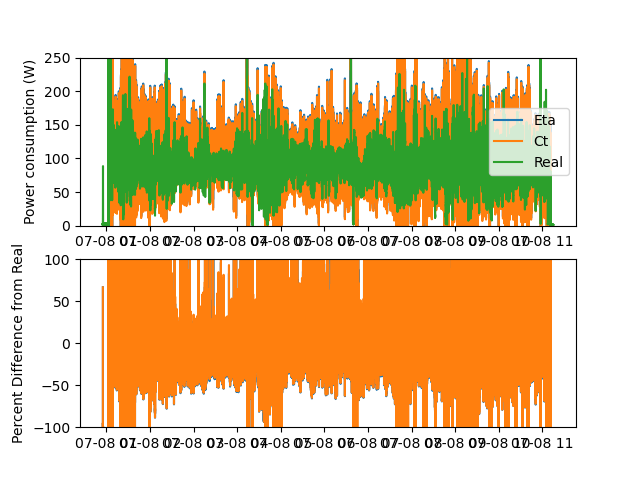

In [10]:
## Plotting
plt.figure()
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index[np.bitwise_and((J < 0.79), (i_esc > 1))], df.ModelPower_eta[np.bitwise_and((J < 0.79), (i_esc > 1))], label='Eta')
ax1.plot(df.index[np.bitwise_and((J < 0.79), (i_esc > 1))], df.ModelPower_ct[np.bitwise_and((J < 0.79), (i_esc > 1))], label='Ct')
ax1.plot(df.index, df.PowerElectrical, label='Real')
ax1.legend(loc='right')
ax1.set_ylabel("Power consumption (W)")
ax1.set_ylim([0,250])

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, df.ModelError_eta, label='\eta')
ax2.plot(df.index, df.ModelError_ct, label='C_T')
ax2.set_ylabel("Percent Difference from Real")
ax2.set_ylim([-100, 100])
plt.show()

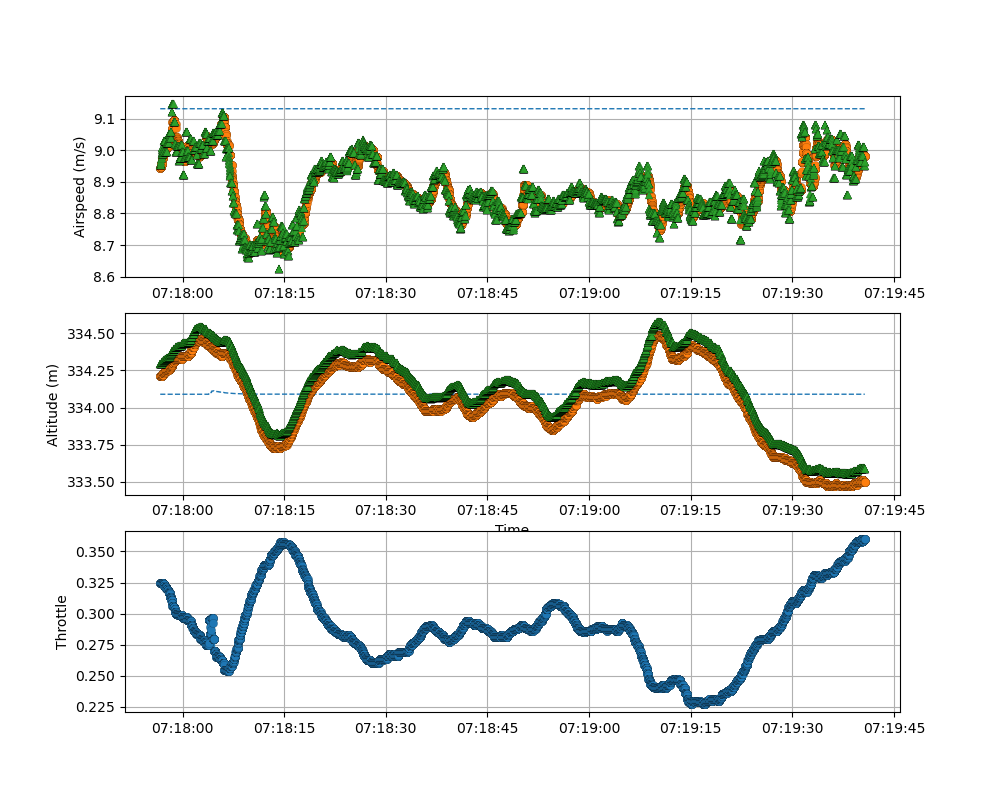

88.65157091516336


In [11]:
# Plotting Data Roughly
# Masking for heading angle range!
range = 3 # Range of heading in degrees
heading_mask = (df["Heading"] < 180 + (range/2)) & (df["Heading"] > 180-(range/2))
heading_mask = heading_mask.replace({True: 1, False: 0})
edge_mask = heading_mask.diff(periods=1)
loiter_mask = (edge_mask == 1) # Mask with True for beginning of each loiter
loiter_times = loiter_mask.loc[loiter_mask == True] # Loiter Series storing loiter number, start time, end time. 

loiter_number = 247 # Selecting the nth loiter of the flight for analysis
mask = cl_finders.mask_fromTime(df, loiter_times.index[loiter_number], loiter_times.index[loiter_number+1])
segment = df[mask]

# Displaying Longitude/Lattitude for loiter
fig = px.scatter_mapbox(segment, 
                        lat="Latitude", 
                        lon="Longitude", 
                        hover_name=segment.index, 
                        #hover_data=["Address", "Listed"],
                        color="PowerElectrical",
                        color_continuous_scale='plasma',
                        size="PowerElectrical",
                        zoom=15, 
                        height=800,
                        width=1200)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Showing airspeed
plt.figure(figsize=(10,8))
ax1 = plt.subplot(3,1,1)
ax1.plot(segment.index, segment.Airspeed_Demanded, linestyle='--', linewidth=1)
ax1.plot(segment.index, segment.Airspeed_CTUN, marker='o', linestyle='', markeredgecolor=[0,0,0], markeredgewidth=0.1)
ax1.plot(segment.index, segment.Airspeed_Sensor0, marker='^', linestyle='', markeredgecolor=[0,0,0], markeredgewidth=0.1)
ax1.set_ylabel("Airspeed (m/s)")
ax1.grid(True)
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')

# Showing Altitude
ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(segment.index, segment.Altitude_Demanded + segment.Altitude_Origin, linestyle='--', linewidth=1)
ax2.plot(segment.index, segment.Altitude_POS, marker='o', linestyle='', markeredgecolor=[0,0,0], markeredgewidth=0.1)
ax2.plot(segment.index, segment.Altitude_TECS + segment.Altitude_Origin, marker='^', linestyle='', markeredgecolor=[0,0,0], markeredgewidth=0.1)
ax2.set_xlabel("Time")
ax2.set_ylabel("Altitude (m)")
ax2.grid(True)
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')

# Showing Throttle
ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(segment.index, segment.Throttle, marker='o', markeredgecolor=[0,0,0], markeredgewidth=0.1)
ax3.set_ylabel("Throttle")
ax3.grid(True)
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')

plt.show()
print(segment.PowerElectrical.mean())


In [12]:
# Initializing Loiter Results Dataframe
frame = {'Heading': loiter_times}
loiter_results = pd.DataFrame(frame)

# Getting Characteristics of Flight
pelec_init = np.zeros(len(loiter_times))
modelerror_init = np.zeros(len(loiter_times))
airspeed_init = np.zeros(len(loiter_times))
airspeedvar_init = np.zeros(len(loiter_times))
# windspeed_init
throttle_init = np.zeros(len(loiter_times))
throttlevar_init = np.zeros(len(loiter_times))
altitudevar_init = np.zeros(len(loiter_times))


for loiter_index in np.arange(0,len(loiter_times)-1):
    mask = cl_finders.mask_fromTime(df, loiter_times.index[loiter_index], loiter_times.index[loiter_index+1])
    segment = df[mask]

    airspeed_init[loiter_index] = segment["Airspeed"].mean()
    airspeedvar_init[loiter_index] = segment["Airspeed"].var()
    pelec_init[loiter_index] = segment["PowerElectrical"].mean()
    throttle_init[loiter_index] = segment["Throttle"].mean()
    throttlevar_init[loiter_index] = segment["Throttle"].var()
    altitudevar_init[loiter_index] = segment["Altitude"].var()
    modelerror_init[loiter_index] = segment["ModelError"].mean()

loiter_results["LoiterNumber"] = np.arange(0,len(loiter_times-1))
loiter_results["AveragePower"] = pelec_init
loiter_results["AverageAirspeed"] = airspeed_init
loiter_results["VarianceAirspeed"] = airspeedvar_init
loiter_results["AverageThrottle"] = throttle_init
loiter_results["VarianceThrottle"] = throttlevar_init
loiter_results["VarianceAltitude"] = altitudevar_init
loiter_results["AverageModelError"] = modelerror_init

In [13]:
## Getting highest power loiters
results = loiter_results.nlargest(int(len(loiter_results)*0.1), "AveragePower")

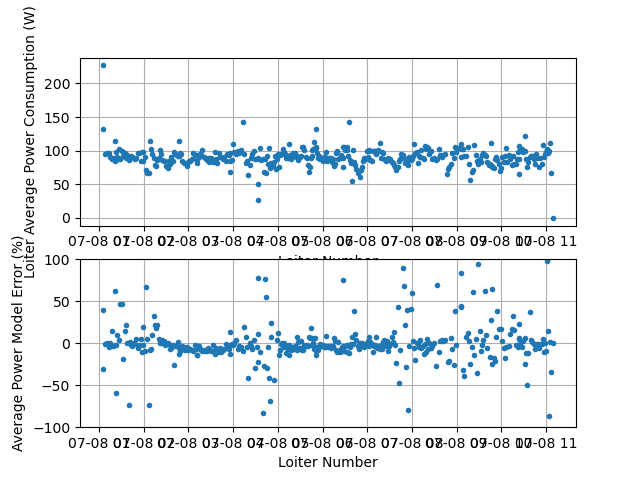

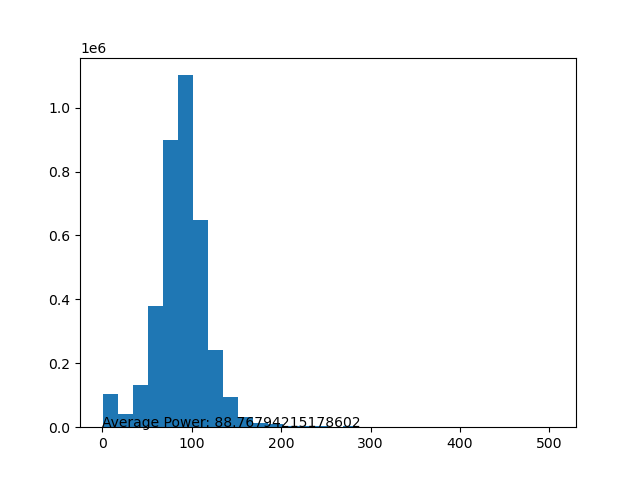

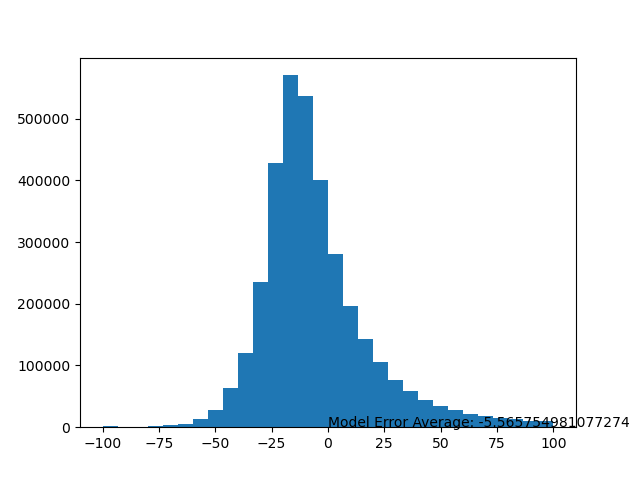

In [14]:
# Plotting Electric Power for Each Loiter
plt.figure()
ax1 = plt.subplot(2,1,1)
ax1.plot(loiter_results.AveragePower, linestyle='', marker='o', markersize=3)
ax1.grid(True)
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.set_xlabel("Loiter Number")
ax1.set_ylabel("Loiter Average Power Consumption (W)")

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(loiter_results.AverageModelError, linestyle='', marker='o', markersize=3)
ax2.set_xlabel("Loiter Number")
ax2.set_ylabel("Average Power Model Error (%)")
ax2.set_ylim([-100,100])
ax2.grid(True)
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
plt.show()

plt.figure()
plt.hist(df["PowerElectrical"], bins=30)
plt.text(0, 300, "Average Power: " + str(df["PowerElectrical"].mean()))
plt.show()

storage = df.ModelError[np.abs(df.ModelError) < 100]
plt.figure()
plt.hist(storage, bins=30)
plt.text(0, 300, "Model Error Average: " + str(storage.mean()))
plt.show()

In [15]:
# Calculating Average Model Errors (Time or loiter based, with some filtering)
print(df.ModelError.mean())  # Error averaged over all time
print(loiter_results.AverageModelError.mean())  # Error averaged by loiters
print(storage.mean())  # Error averaged by loiter for errors higher than 100% removed

1.0525049315370683
3.0630720269834284
-5.565754981077274


In [16]:
# Getting Correlation Matrix for Worst Loiters
corrM = results.corr()
fig = px.imshow(corrM)
fig.update_layout(width=1200, height=1200)
fig.show()

In [17]:
print(results.AverageModelError.mean())

0.38351249507559343
